In [1]:
import pandas as pd
from Utils import Utils
from EDA import EDA

### 1. First, the dataset needs to be loaded. For the sake of simplicity, we are gonna use an object for loading and cleaning the dataset.

In [2]:
data_cleaner = Utils('assets/auto_train.csv')
data_cleaner.show_head()
df = data_cleaner.df

c:\Users\Luca Petrescu\Desktop\Master\Anul 1\Semestrul 2\DMDA\Curs\Tema 2\Utils.py:13: DtypeWarning: Columns (41,56) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(self.file_path)


 ##### 1. a. Checking the missing values
To understand the dataset, we need to se whick columns contain missing values

In [3]:
data_cleaner.get_nan_values()

id                                         0
data                                       0
nume                                       0
pret                                       0
url                                        0
Oferit de                                  0
Are VIN (Serie sasiu)                   8201
Marca                                      0
Model                                      0
Versiune                                4110
Anul fabricației                           0
Km                                        55
Combustibil                                0
Putere                                     7
Capacitate cilindrica                    554
Transmisie                              2184
Consum Extraurban                      11012
Cutie de viteze                            1
Consum Urban                            6150
Tip Caroserie                              0
Emisii CO2                              9621
Numar de portiere                        181
Culoare   

##### 1. b. Cleaning the dataset of NaN columns
We are gonna drop the columns where at least 2/3 of the data is missing.

In [4]:
data_cleaner.delete_columns_with_nans()

Deleted column 'sau in limita a' with 16600 NaN values (more than 66.0% of the rows)
Deleted column 'Garantie dealer (inclusa in pret)' with 14079 NaN values (more than 66.0% of the rows)
Deleted column 'Garantie de la producator pana la' with 18310 NaN values (more than 66.0% of the rows)
Deleted column 'Vehicule electrice' with 16811 NaN values (more than 66.0% of the rows)
Deleted column 'Tuning' with 19313 NaN values (more than 66.0% of the rows)
Deleted column 'Contract baterie' with 19273 NaN values (more than 66.0% of the rows)
Deleted column 'Masina de epoca' with 19481 NaN values (more than 66.0% of the rows)
Deleted column 'Volan pe dreapta' with 19465 NaN values (more than 66.0% of the rows)
Deleted column 'Predare leasing' with 19397 NaN values (more than 66.0% of the rows)
Deleted column 'Plata initiala (la predare)' with 19471 NaN values (more than 66.0% of the rows)
Deleted column 'Autonomie' with 19175 NaN values (more than 66.0% of the rows)
Deleted column 'Consum medi

##### 1. c. Check the rest of the missing values in the columns

To see what has to be done next in the cleaning phase, wee need to see which columns have missing values. We are gonna do that for both numerical and object columns

In [5]:
numeric_columns = data_cleaner.df.select_dtypes(include=['number'])
numeric_columns_with_nan = numeric_columns.columns[numeric_columns.isna().any()].tolist()
numeric_df_with_nan = df[numeric_columns_with_nan]
numeric_df_with_nan.info()
numeric_dataframe = pd.DataFrame(numeric_df_with_nan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19526 entries, 0 to 19525
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Km                     19471 non-null  float64
 1   Putere                 19519 non-null  float64
 2   Capacitate cilindrica  18972 non-null  float64
 3   Consum Extraurban      8514 non-null   float64
 4   Consum Urban           13376 non-null  float64
 5   Emisii CO2             9905 non-null   float64
 6   Numar de portiere      19345 non-null  float64
 7   Numar locuri           15264 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


In [6]:
object_columns = data_cleaner.df.select_dtypes(include=['object'])
object_columns_with_nan = object_columns.columns[object_columns.isna().any()].tolist()
object_df_with_nan = df[object_columns_with_nan]
object_df_with_nan.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19526 entries, 0 to 19525
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Are VIN (Serie sasiu)                11325 non-null  object
 1   Versiune                             15416 non-null  object
 2   Transmisie                           17342 non-null  object
 3   Cutie de viteze                      19525 non-null  object
 4   Se emite factura                     9541 non-null   object
 5   Eligibil pentru finantare            9428 non-null   object
 6   Primul proprietar (de nou)           8066 non-null   object
 7   Fara accident in istoric             12135 non-null  object
 8   Carte de service                     12272 non-null  object
 9   VIN (serie sasiu)                    11330 non-null  object
 10  Audio si tehnologie                  18980 non-null  object
 11  Confort si echipamente optionale     1939

In [7]:
numeric_outliers = data_cleaner.detect_outliers(numeric_dataframe)
print(numeric_outliers)
for col, outliers in numeric_outliers.items():
    print(f"Outliers in column '{col}':")
    print(outliers)
    print()


{'Km': 983       588000.0
1530      602000.0
2546     2080288.0
2982      488894.0
3208      510000.0
3323      500000.0
4729      620000.0
4754      412000.0
4937      489094.0
5058      412817.0
5340      411000.0
5696      504000.0
5724      440000.0
5733      502883.0
5898      413769.0
5999      469000.0
6640      458000.0
7405      550000.0
7481      449884.0
8543      450000.0
8862      418180.0
8906      415000.0
8931      575000.0
9019      800000.0
9268      547000.0
9410     1200002.0
10431     410000.0
11958     556000.0
12147     432631.0
12180     575000.0
12666     432280.0
13828     488504.0
14526     441903.0
14986     539151.0
15230     450000.0
15616     412000.0
16596     428000.0
16696     455000.0
16842     560000.0
17629     435000.0
17910     440000.0
18079     450000.0
18087     559780.0
18263     450000.0
18369    1630000.0
18890     572598.0
19196     413000.0
Name: Km, dtype: float64, 'Putere': 28       340.0
39       351.0
40       381.0
56       550.0
64  

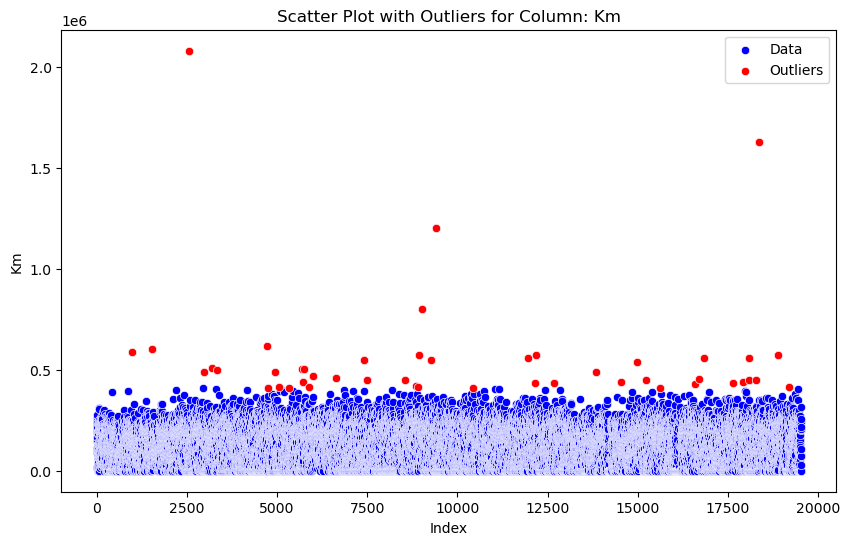

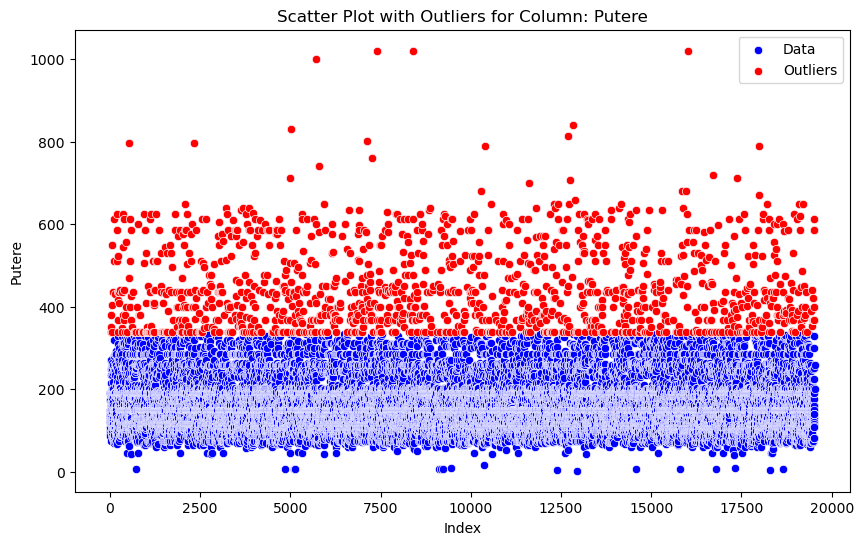

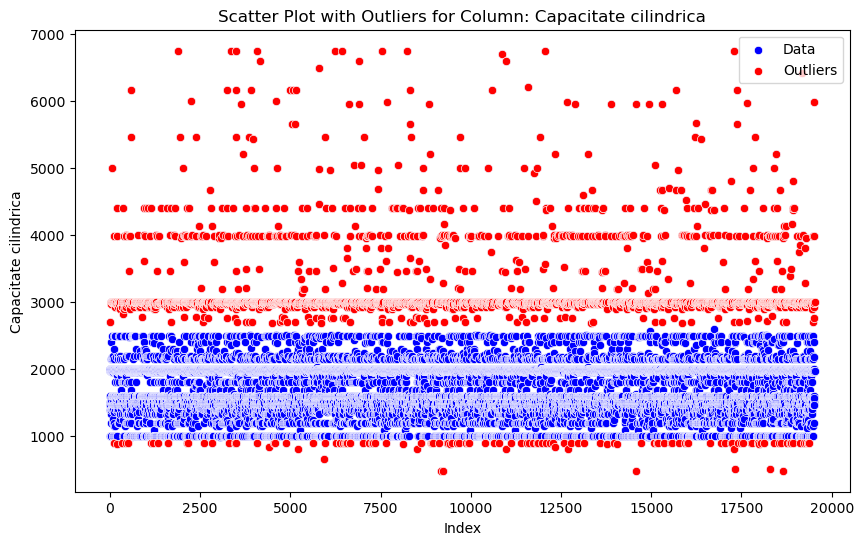

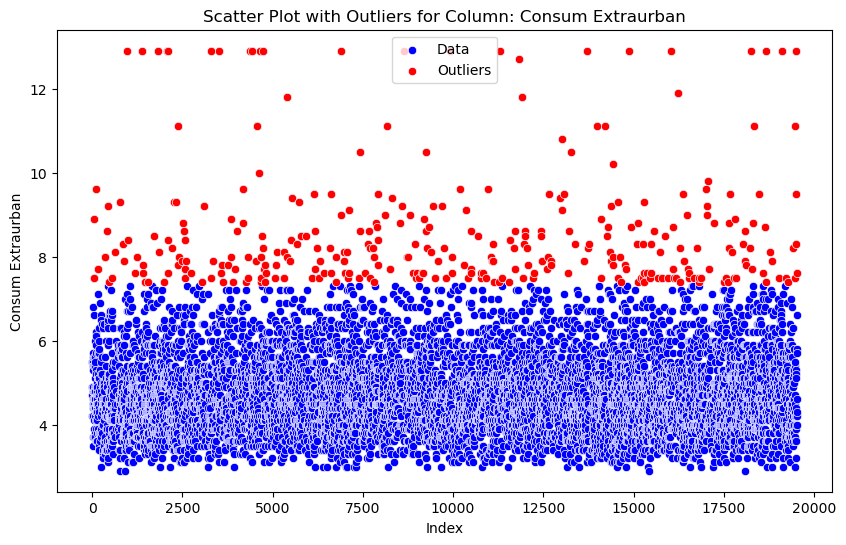

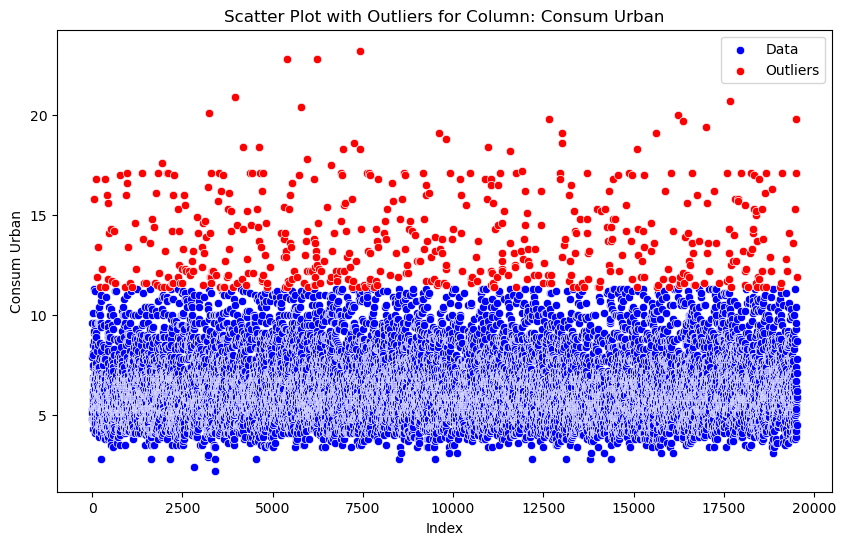

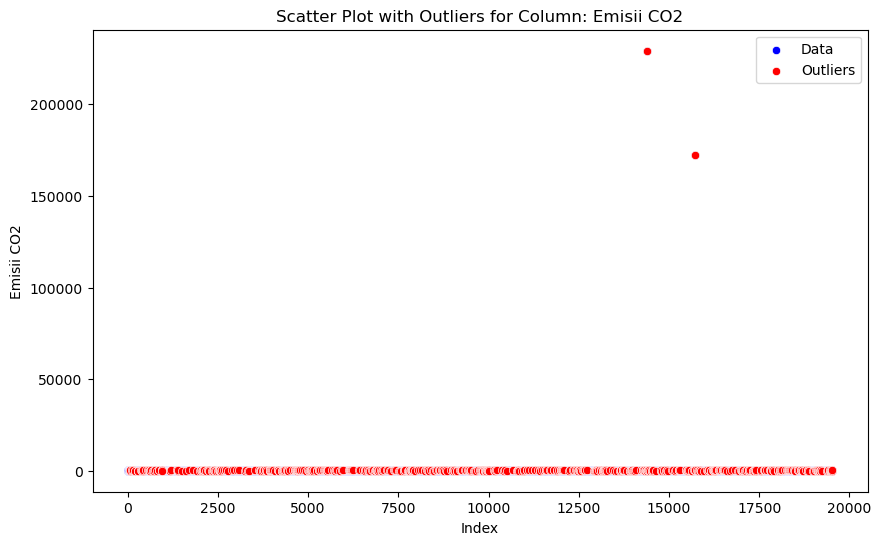

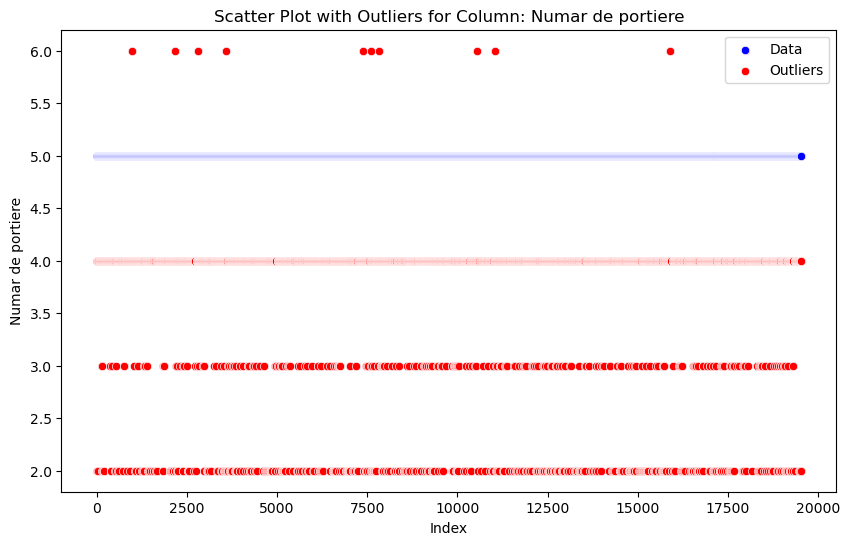

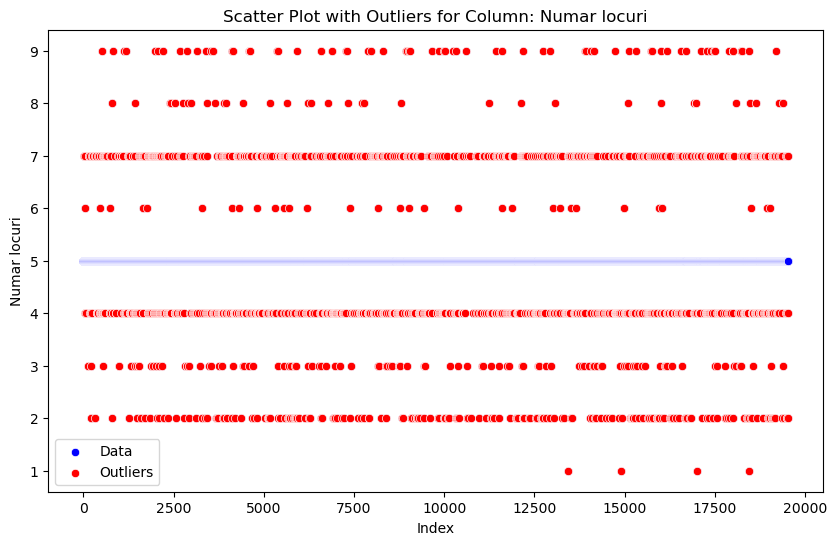

In [8]:
data_cleaner.plot_outliers_scatter(numeric_dataframe, numeric_outliers)

In [9]:
data_cleaner.fill_nan_with_median()
object_df_with_nan.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19526 entries, 0 to 19525
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Are VIN (Serie sasiu)                11325 non-null  object
 1   Versiune                             15416 non-null  object
 2   Transmisie                           17342 non-null  object
 3   Cutie de viteze                      19525 non-null  object
 4   Se emite factura                     9541 non-null   object
 5   Eligibil pentru finantare            9428 non-null   object
 6   Primul proprietar (de nou)           8066 non-null   object
 7   Fara accident in istoric             12135 non-null  object
 8   Carte de service                     12272 non-null  object
 9   VIN (serie sasiu)                    11330 non-null  object
 10  Audio si tehnologie                  18980 non-null  object
 11  Confort si echipamente optionale     1939

In [10]:
data_cleaner.detect_categorical_data()

Column 'Oferit de' is categorical with 2 unique values.
Column 'Are VIN (Serie sasiu)' is categorical with 1 unique values.
Column 'Transmisie' is categorical with 4 unique values.
Column 'Cutie de viteze' is categorical with 2 unique values.
Column 'Se emite factura' is categorical with 1 unique values.
Column 'Eligibil pentru finantare' is categorical with 1 unique values.
Column 'Primul proprietar (de nou)' is categorical with 1 unique values.
Column 'Fara accident in istoric' is categorical with 1 unique values.
Column 'Carte de service' is categorical with 1 unique values.
Column 'Stare' is categorical with 2 unique values.
Column 'VIN (serie sasiu)' is categorical with 1 unique values.
Column 'Optiuni culoare' is categorical with 3 unique values.
Column 'Inmatriculat' is categorical with 1 unique values.


['Oferit de',
 'Are VIN (Serie sasiu)',
 'Transmisie',
 'Cutie de viteze',
 'Se emite factura',
 'Eligibil pentru finantare',
 'Primul proprietar (de nou)',
 'Fara accident in istoric',
 'Carte de service',
 'Stare',
 'VIN (serie sasiu)',
 'Optiuni culoare',
 'Inmatriculat']

In [11]:
data_cleaner.fill_nan_with_frequent()

For column 'Are VIN (Serie sasiu)', filled NaN with 'Da'
For column 'Versiune', filled NaN with 'xDrive30d'
For column 'Transmisie', filled NaN with 'Fata'
For column 'Cutie de viteze', filled NaN with 'Automata'
For column 'Se emite factura', filled NaN with 'Da'
For column 'Eligibil pentru finantare', filled NaN with 'Da'
For column 'Primul proprietar (de nou)', filled NaN with 'Da'
For column 'Fara accident in istoric', filled NaN with 'Da'
For column 'Carte de service', filled NaN with 'Da'
For column 'VIN (serie sasiu)', filled NaN with 'Vezi VIN-ul (seria de sasiu)'
For column 'Audio si tehnologie', filled NaN with '['Radio']'
For column 'Confort si echipamente optionale', filled NaN with '['Aer conditionat', 'Geamuri electrice fata', 'Geamuri electrice spate']'
For column 'Electronice si sisteme de asistenta', filled NaN with '['Servodirectie']'
For column 'Siguranta', filled NaN with '['ABS', 'ESP', 'EBD', 'Franare asistata', 'Airbag sofer', 'Airbag scaun pasager', 'Airbag-uri 

In [13]:
EDA_analyzer = EDA(df)
# EDA_analyzer.show_distribution()
df.head()

,id,data,nume,pret,url,Oferit de,Are VIN (Serie sasiu),Marca,Model,Versiune,...,Confort si echipamente optionale,Electronice si sisteme de asistenta,Siguranta,Generatie,Norma de poluare,Optiuni culoare,Tara de origine,Data primei inmatriculari,Performanta,Inmatriculat
0,7053131628,2024-03-06 11:49:00,Volkswagen Tiguan 2.0 TDI 4Motion DSG Sport & ...,9999.0,https://www.autovit.ro/autoturisme/anunt/volks...,Firma,Da,Volkswagen,Tiguan,2.0 TDI 4Motion DSG Sport & Style,...,"['Climatronic 3 zone', 'Tapiterie alcantara', ...","['Pilot automat', 'Senzori parcare spate', 'Og...","['ABS', 'ESP', 'EBD', 'Airbag sofer', 'Airbag ...",B8 [2014 - Prezent],Euro 6,Metalizata,Germania,2019-08-06,['Jante otel'],Da
1,7053116553,2024-03-06 11:37:00,Opel Astra,3150.0,https://www.autovit.ro/autoturisme/anunt/opel-...,Firma,Da,Opel,Astra,xDrive30d,...,"['Climatronic', 'Top stofa', 'Tapiterie stofa'...","['Pilot automat', 'Oglinzi exterioare cu regla...","['ABS', 'ESP', 'Airbag sofer', 'Airbag scaun p...",G [1998 - 2005],Euro 4,Metalizata,Germania,2002-12-15,"['Jante aliaj 15', 'Anvelope iarna']",Da
2,7052933182,2024-03-06 11:37:00,Dacia Duster,17790.0,https://www.autovit.ro/autoturisme/anunt/dacia...,Firma,Da,Dacia,Duster,xDrive30d,...,"['Climatronic', 'Incalzire scaun sofer', 'Inca...","['Pilot automat', 'Faruri LED', 'Senzori parca...","['ABS', 'ESP', 'EBD', 'Franare asistata', 'Air...",II [2018 - Prezent],Euro 6,Metalizata,Polonia,2023-04-12,['Jante aliaj 17'],Da
3,7053100111,2024-03-06 11:37:00,BMW X4 xDrive20d Aut. M Sport,24990.0,https://www.autovit.ro/autoturisme/anunt/bmw-x...,Firma,Da,BMW,X4,xDrive20d Aut. M Sport,...,"['Climatronic 2 zone', 'Trapa electrica', 'Tap...","['Pilot automat', 'Faruri LED', 'Senzori parca...","['ABS', 'ESP', 'Sistem pre-coliziune lateral',...",B8 [2014 - Prezent],Euro 6,Metalizata,Germania,2019-08-06,"['Jante aliaj 18', 'Cauciucuri Run-flat', 'Sus...",Da
4,7053209893,2024-03-06 11:41:00,Dacia Duster dCi 110 4WD Prestige,9790.0,https://www.autovit.ro/autoturisme/anunt/dacia...,Privat,Da,Dacia,Duster,dCi 110 4WD Prestige,...,"['Aer conditionat', 'Tapiterie stofa', 'Cotier...","['Pilot automat', 'Senzori parcare spate', 'Og...","['ABS', 'ESP', 'EBD', 'Franare asistata', 'Air...",B8 [2014 - Prezent],Euro 5,Metalizata,Belgia,2014-04-17,['Jante otel'],Da
